# 0. 뉴스 요약 봇 만들기

뉴스를 요약해보자.

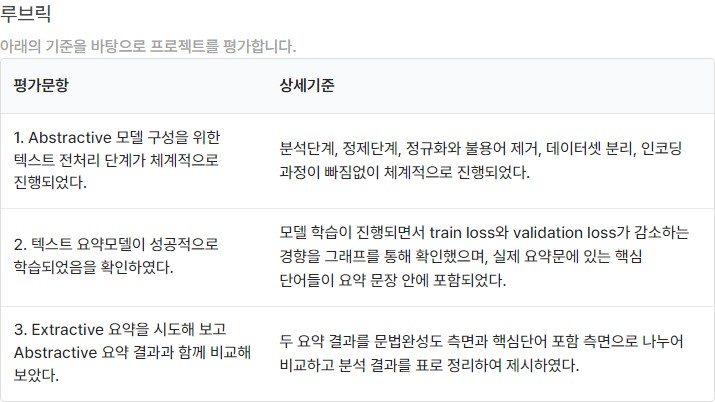

In [77]:
import os, re
import time
from tqdm import tqdm

import urllib.request
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from summa.summarizer import summarize
import random

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.  
https://github.com/sunnysai12345/News_Summary

In [78]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [79]:
print('전체 샘플수 :', (len(data)))
data.head()

전체 샘플수 : 98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


headlines 열은 요약문, text는 원문이다.

개인적으로 보기 편하게 하기 위해 headlines와 text 열 위치 변경 및 headlines 변수명을 Summary로 변경.

In [80]:
data = data[['text', 'headlines']]
data.columns = ['Text', 'Summary']
data.head()

,Text,Summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


텍스트 요약에는 크게 두 가지가 있다.  
바로 추출적 요약(Extractive Summarization)과 추상적 요약(Abstractive Summarization)이다.

추출적 요약은 원문에서 중요해 보이는 문장들을 그대로 추출해 주는 방법이다.  
이 방법의 단점은 문장의 연결이 매끄럽지 않다는 것이다.  

추상적 요약은 요약 문장을 자체적으로 생성하는 방법이다.
이 방법의 단점은 모델 성능이 떨어지면 그냥 딴소리를 한다는 것이다.  
하지만 성능만 좋다면 추출적 요약의 상위호환이다.

우선 추상적 요약부터 해보겠다.

# 2. 데이터 전처리하기 (추상적 요약)

## 2.1. 데이터 정리하기 (추상적 요약)

### 2.1.1. 중복 샘플 제거 NULL 값이 존재하는 샘플 제거 (추상적 요약)

In [81]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


Summary는 이론적으로 중복이 될 수도 있다고 생각이 들지만,  
Text는 중복이 되면 덩달아서 Summary도 중복이 되기 때문에 데이터 자체가 중복되서  
Text 중복 데이터만 삭제하도록 한다.

In [82]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수:', (len(data)))

전체 샘플수: 98360


In [83]:
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


null값은 없다.

In [84]:
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

### 2.1.2. 텍스트 정규화와 불용어 제거 (추상적 요약)

"isn't"와 "is not"은 같은 의미다.  
하지만 컴퓨터는 그것을 모른다.  
따라서 직접 변환해주어야 한다.  
이렇게 하면 연산량도 줄일 수가 있다.  
이러한 방식을 "텍스트 정규화(text normalization)라고 한다.

아래는 축약형과 변환할 원형의 쌍들이 담긴 사전이다.
https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [85]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


대부분의 언어에는 불용어(stopwords)라는 학습에 도움이 안되는 단어들이 존재한다.
NLTK 라이브러리에서 stopwords를 다운받고 영어 불용어를 불러와보자.

In [86]:
# nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

정규화, 불용어 제거 등의 전처리를 해주는 함수를 만들어보자.

In [87]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
     
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


Summary 변수에서는 불용어를 제거하지 않는 게 더 자연스럽기 때문에  
불용어 제거 여부 하이퍼 퍼래머더를 만든다.

In [88]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


실제 전처리 시 시간이 오래 걸리기 때문에 tqdm 함수를 이용해서  
진행률을 볼 수 있기 조치를 취한다.

In [89]:
start = time.time()

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
tqdm.pandas()
clean_text = data['Text'].progress_apply(preprocess_sentence)

# 전처리 후 출력
print(len(clean_text))
print("Text 전처리 후 결과: ", clean_text[:5], sep='\n')

end = time.time()
print('time:', end - start)

100%|██████████| 98360/98360 [07:52<00:00, 208.08it/s]

98360
Text 전처리 후 결과: 
0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: Text, dtype: object
time: 472.7098174095154


In [90]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


이렇게 전처리가 끝났다.  
하지만 매우 혹시나 전처리 후에 텅 비어버린 값들이 있을 수 있으니 확인해보자.

In [91]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [92]:
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [93]:
# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

## 2.2. 훈련데이터와 테스트데이터 나누기 (추상적 요약)

### 2.2.1. 샘플의 최대 길이 정하기 (추상적 요약)

학습을 할 때 데이터의 길이가 일괄적이여야 되기 때문에  
적당한 최대 길이를 정해서 최대 길이를 넘는 데이터들은 제거해야한다.  
따라서 적당한 최대 길이를 알아보기 위해 그래프를 그려보자.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


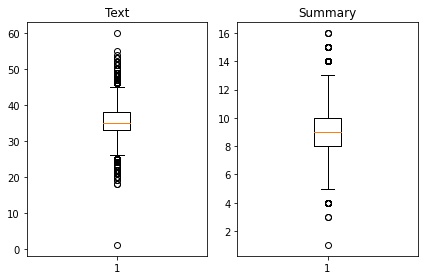

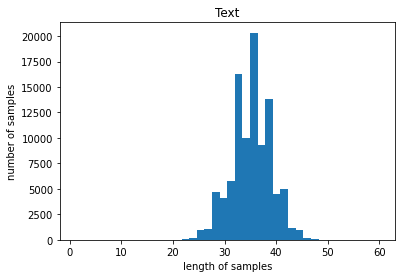

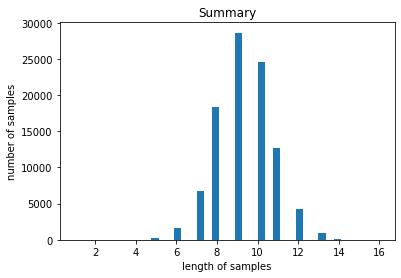

In [94]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

텍스트의 토큰은 1 ~ 60개, 평균 35개가 들어있고 요약의 토큰은 1 ~ 16개, 평균 9개가 들어있다.

최대 길이에 따라 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하기 위한 함수를 생성해보자.

In [95]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [96]:
below_threshold_len(40, data['Text'])
below_threshold_len(39, data['Text'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 39 이하인 샘플의 비율: 0.8782126880845872


최대 길이를 점점 낮춰본 결과 텍스트의 최대 길이가 39개일 때 부터  
포한되는 데이터가 90% 미만이 되므로 최대 길이를 40으로 결정한다.

In [97]:
text_max_len = 40

In [98]:
old_text_len = len(data)
print('기존 샘플 수:', old_text_len)
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :', len(data))
print('제거된 샘플 수:', old_text_len - len(data))

기존 샘플 수: 98360
전체 샘플수 : 90872
제거된 샘플 수: 7488


In [99]:
below_threshold_len(11,  data['Summary'])
below_threshold_len(10,  data['Summary'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9446584206356193
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8154547055198521


최대 길이를 점점 낮춰본 결과 요약의 최대 길이가 10개일 때 부터  
포한되는 데이터가 90% 미만이 되므로 최대 길이를 11으로 결정한다.

In [100]:
summary_max_len = 11

In [101]:
old_summary_len = len(data)
print('기존 샘플 수:', old_summary_len)
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', len(data))
print('제거된 샘플 수:', old_summary_len - len(data))

기존 샘플 수: 90872
전체 샘플수 : 85843
제거된 샘플 수: 5029


### 2.2.2. 시작 토큰과 종료 토큰 추가하기 (추상적 요약)

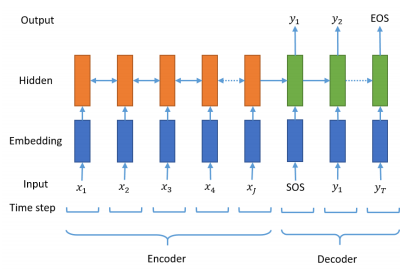

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.  
따라서 시작 토큰을 앞에 추가한 input과 종료 토큰을 뒤에 추가한 target 변수를 생성한다.

In [102]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [103]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

학습을 위해 데이터를 ndarray로 만든 변수를 생성.

원활한 학습을 위해 필수적인 shuffle.

In [104]:
indices = np.arange(encoder_input.shape[0])
np.random.seed(9)
np.random.shuffle(indices)
print(indices)

[52035  3263  2156 ... 65462 66037 55934]


In [105]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

이제 훈련 데이터와 평가 데이터를 8:2로 분리해보자.

In [106]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [107]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


## 2.3. 정수 인코딩 (추상적 요약)

### 2.3.1. 단어 집합(vocabulary) 만들기 및 정수 인코딩 (추상적 요약)

학습을 위해 단어를 숫자로 바꿔줘야 한다.  
이를 위해서는 각 단어와 정수를 매핑해야한다.  
이 매핑된 집합을 단어 집합이라고 한다.

In [108]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 집합 중 빈도수가 낮은 단어들은 훈련 데이터에서 제외하는 게 좋아보인다.  
특정 빈도수 미만인 단어들의 비중을 확인해보자.

In [109]:
threshold = 26
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64807
등장 빈도가 25번 이하인 희귀 단어의 수: 55000
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9807
단어 집합에서 희귀 단어의 비율: 84.8673754378385
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.746838324373039


64807개의 단어 중에서 희귀 단어 55000개를 제외한 약 10000개의 단어만 남겨도  
(100% - 9.7% =) 약 90% 비중이 살아있므로 단어의 크기를 10000개로 제한한다.

In [110]:
src_vocab = 10000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 10,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [111]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[250, 1483, 3371, 1172, 2092, 422, 843, 128, 673, 956, 1497, 3240, 139, 4997, 35, 1397, 732, 38, 200, 3877, 2357, 956, 4997, 339, 86, 1214, 5801, 1214, 252, 1405], [142, 4998, 35, 3091, 54, 45, 1844, 112, 2, 136, 2838, 107, 142, 4741, 22, 220, 666, 722, 1, 4998, 347, 968, 4999, 797, 4045, 584, 1304, 136, 1479], [663, 1669, 473, 651, 2247, 617, 158, 13, 6479, 348, 5, 28, 3, 1249, 6, 105, 663, 336, 5147, 805, 1015, 1977, 467, 547, 164, 1701, 1640, 1390, 1427, 48, 1882, 2247, 278]]


In [112]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [113]:
threshold = 26
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28445
등장 빈도가 25번 이하인 희귀 단어의 수: 22486
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 5959
단어 집합에서 희귀 단어의 비율: 79.05079978906662
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.682766512933167


28445개의 단어 중에서 희귀 단어 22486개를 제외한 약 6000개의 단어만 남겨도  
(100% - 9.7% =) 약 90% 비중이 살아있므로 단어의 크기를 6000개로 제한한다.

In [114]:
tar_vocab = 6000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('target ',decoder_target_train[:5])

input
input  [[1, 21, 1325, 1134, 3, 2784, 98], [1, 3982, 16, 3, 61, 4, 1205, 85, 355, 35], [1, 372, 1228, 5, 2480, 1951, 10, 4445, 1107, 4, 2248, 528], [1, 2300, 598, 3, 2013, 25, 331, 4], [1, 673, 38, 3421, 3, 2716, 158, 5655, 2301]]
target
target  [[21, 1325, 1134, 3, 2784, 98, 2], [3982, 16, 3, 61, 4, 1205, 85, 355, 35, 2], [372, 1228, 5, 2480, 1951, 10, 4445, 1107, 4, 2248, 528, 2], [2300, 598, 3, 2013, 25, 331, 4, 2], [673, 38, 3421, 3, 2716, 158, 5655, 2301, 2]]


희귀 단어는 아예 숫자로 변환이 안되기 때문에 시작 토큰 혹은 종료 토큰만 남은  
데이터가 존재할 수 있으므로 제거한다.

In [115]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


### 2.3.2. 패딩하기 (추상적 요약)

서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 한다.

In [116]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')

encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

# 3. 어텐션 메커니즘 사용하기 (추상적 요약)

## 3.1. 모델 설계하기 (추상적 요약)

RNN 모델을 설계해보자. LSTM 레이어를 사용한다.

### 3.1.1. 인코더, 디코더 설계하기 (추상적 요약)

seq2seq 모델은 인코더와 디코더 모델을 연결시켜서 만드는 모델이다.  
그래서 seq2seq 모델얼 Encoder-Decoder 모델이라고도 부른다.  
우선 인코더부터 설계해보자.

In [117]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

LSTM이 3층인 모델이다. 중요한 점은 중간 lstm의 state들은 쓸모가 없고  
output만 필요하다는 것이다.  
이번엔 디코더를 설계해보자.

In [118]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

여기서 중요한 점은 인코더의 최종 스테이트들을 lstm의 initial_state로 삼는다는 점이다.

In [119]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 128)      1280000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 40, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

모델을 시각화해보자.

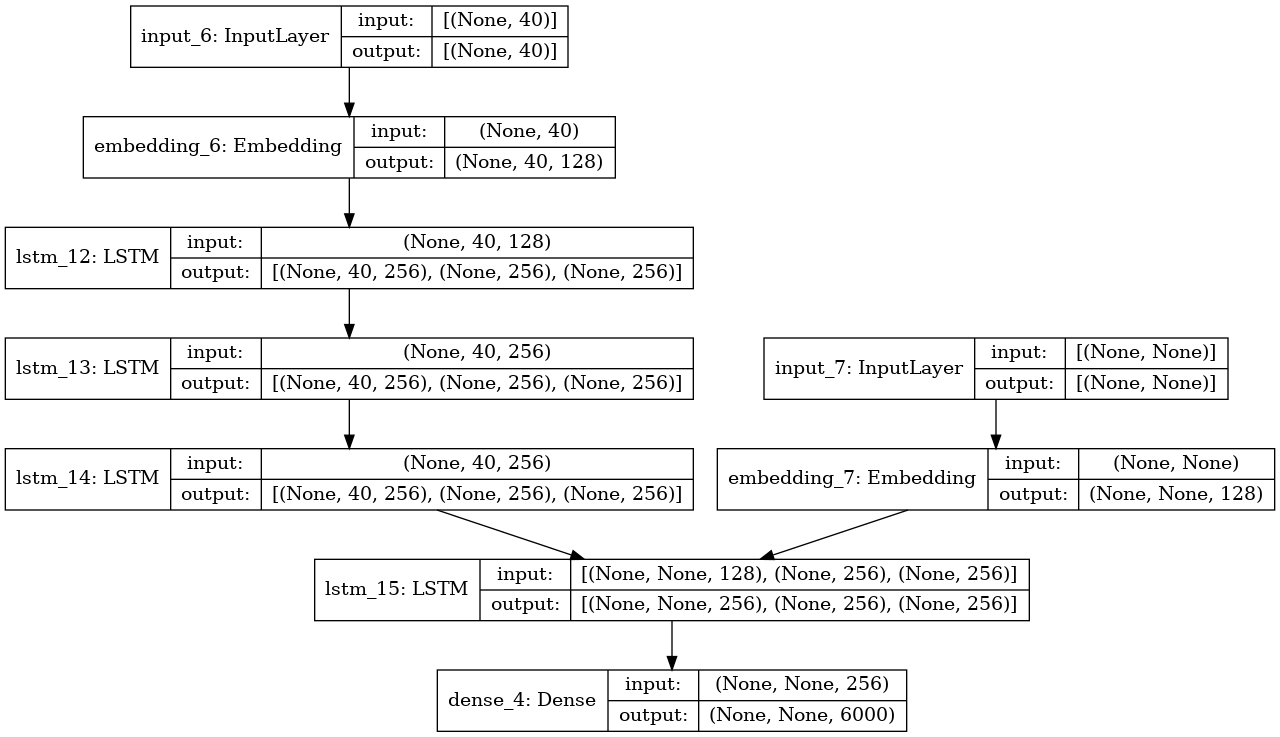

In [120]:
plot_model(model, show_shapes=True)

### 3.1.2. 어텐션 메커니즘 (추상적 요약)

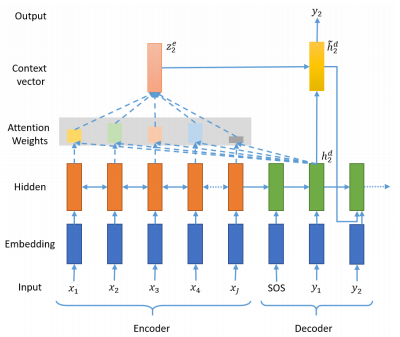

어텐션 메커니즘은 입력 시퀀스의 정보 손실을 방지하고자  
인코더의 모든 step의 정보를 반영되도록 해주는 메커니즘이다.  
어텐션 레이어를 간단하게 쌓아보도록 하자.

In [121]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 40, 128)      1280000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 40, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

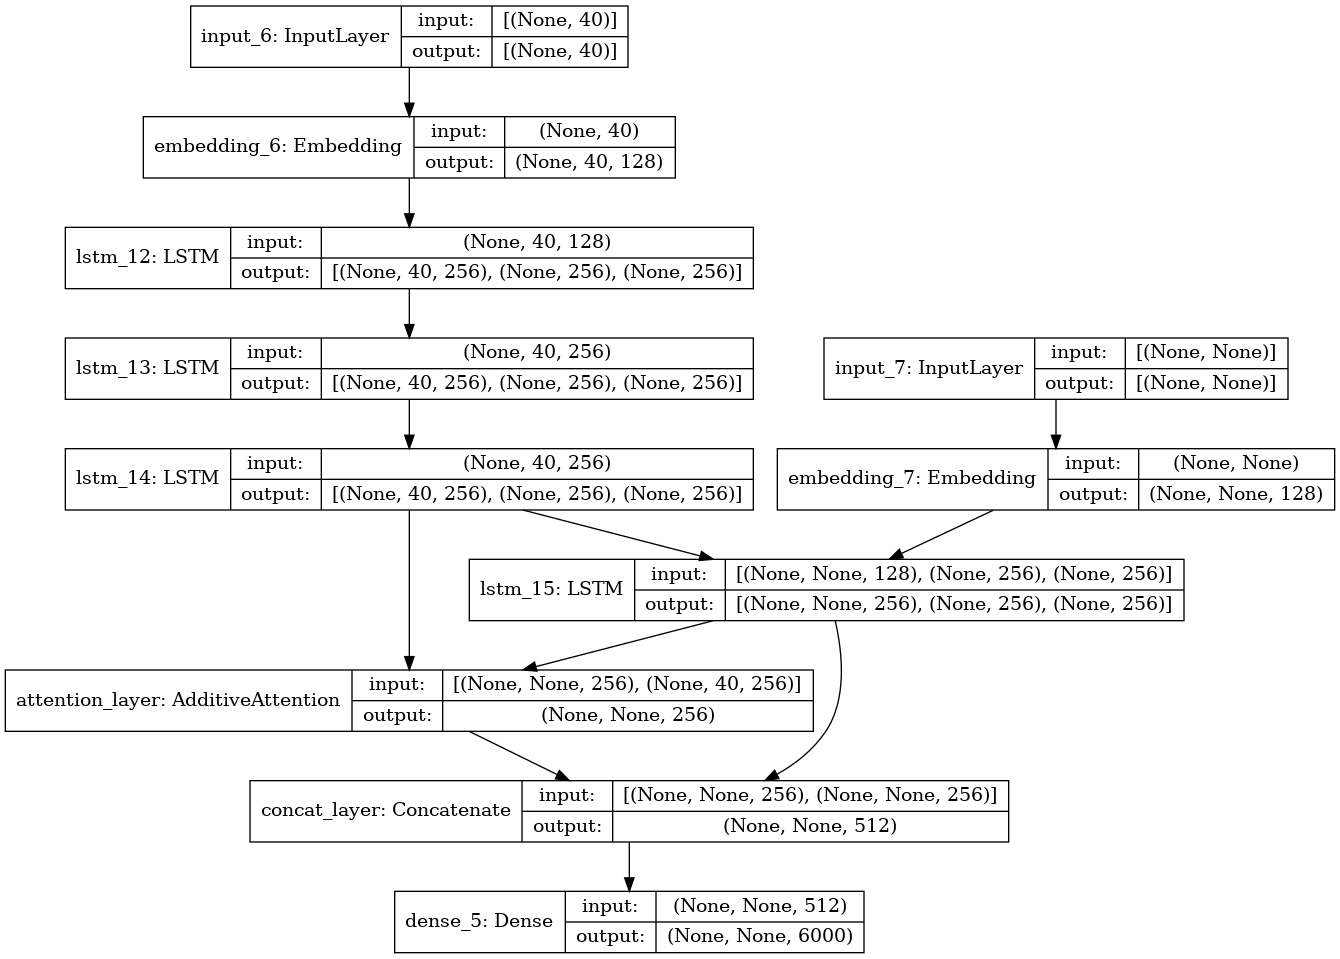

In [122]:
plot_model(model, show_shapes=True)

모델이 약간 수정되었는데  
인코더의 가중합에 따라 decoder lstm output이 달라지도록 하는  
attention 레이어를 지나서  
나온 output과 decoder lstm output 다시 concate 시킨다.

## 3.2. 모델 훈련하기 (추상적 요약)

In [123]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 28s 83ms/step - loss: 5.5545 - accuracy: 0.2688 - val_loss: 5.1539 - val_accuracy: 0.2943
Epoch 2/50
269/269 [==============================] - 22s 80ms/step - loss: 4.9962 - accuracy: 0.2969 - val_loss: 4.7892 - val_accuracy: 0.3080
Epoch 3/50
269/269 [==============================] - 22s 81ms/step - loss: 4.6602 - accuracy: 0.3126 - val_loss: 4.5448 - val_accuracy: 0.3227
Epoch 4/50
269/269 [==============================] - 22s 82ms/step - loss: 4.3895 - accuracy: 0.3281 - val_loss: 4.3290 - val_accuracy: 0.3374
Epoch 5/50
269/269 [==============================] - 22s 83ms/step - loss: 4.1758 - accuracy: 0.3420 - val_loss: 4.1765 - val_accuracy: 0.3491
Epoch 6/50
269/269 [==============================] - 22s 84ms/step - loss: 4.0013 - accuracy: 0.3538 - val_loss: 4.0653 - val_accuracy: 0.3569
Epoch 7/50
269/269 [==============================] - 23s 84ms/step - loss: 3.8514 - accuracy: 0.3654 - val_loss: 3.9886 - val_accuracy:

정확도가 형편이 없다. 그래도 한 번 학습이 잘 진행되었는지 확인해보자.

In [124]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [125]:
def history_plot(history):
    y_acc = history.history['accuracy']
    y_vacc = history.history['val_accuracy']
    
    y_loss = history.history['loss']
    y_vloss = history.history['val_loss']

    epochs_range = range(len(y_acc))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, y_acc, marker='.', label="Train-set accuracy")
    plt.plot(epochs_range, y_vacc, marker='.', label="Validation-set accuracy")
    plt.legend(loc='lower right')
    plt.grid()
    plt.title('Accurcy graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, y_loss, marker='.', label="Train-set Loss")
    plt.plot(epochs_range, y_vloss, marker='.', label="Validation-set Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Loss graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.show()

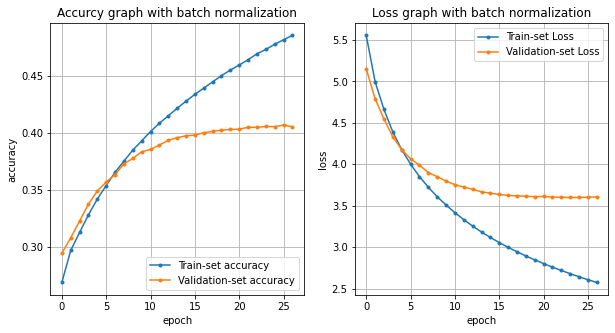

In [126]:
history_plot(history)

정확도가 낮은 걸 보니 모델을 좀 더 깊게 쌓아도 될 것 같아 보이고  
accuracy와 val_accuracy가 차이나는 것을 보아 규제도 필요한 것 같다.

모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했다.

## 3.3. 인퍼런스 모델 구현하기 (추상적 요약)

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로  
필요한 3개의 사전을 준비한다.

In [127]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비하면 된다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [128]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

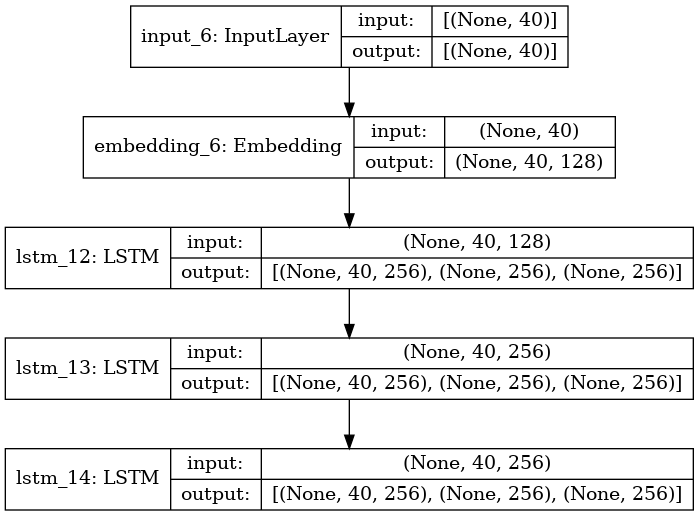

In [129]:
plot_model(encoder_model, show_shapes=True)

In [130]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [131]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

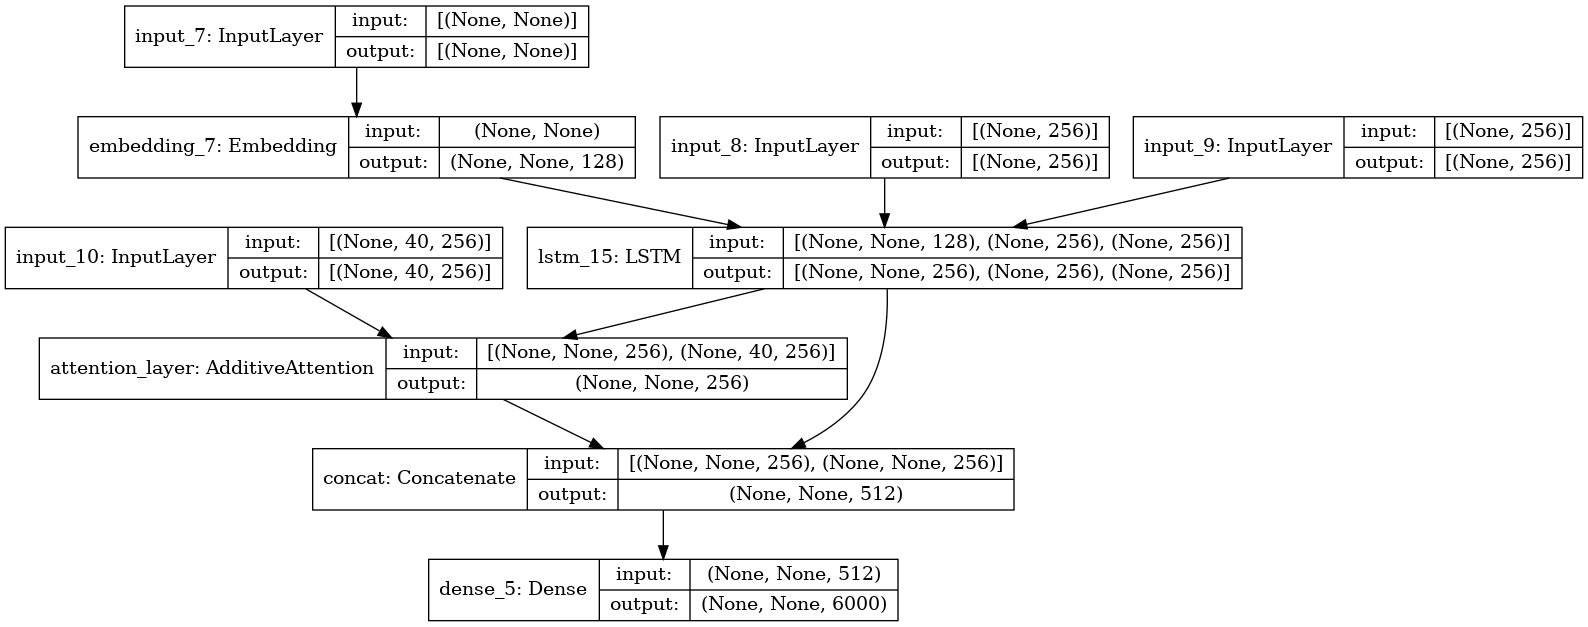

In [132]:
plot_model(decoder_model, show_shapes=True)

종합적으로 텍스트를 넣으면 요약해주는 함수를 구현.

In [133]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


# 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [134]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [135]:
for i in range(5):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")
    

원문 : ms dhoni become first cricketer reach eight ipl finals following csk victory srh ipl qualifier tuesday year old led csk six finals winning twice played rising pune supergiant last year final scored runs seven previous finals strike rate 
실제 요약 : ms dhoni reaches his ipl final in 
예측 요약 :  dhoni hits ipl season with most ipl


원문 : changing names central government schemes bjp leader chandra kumar bose compared west bengal cm mamata banerjee mughal emperor demolished ram temple ayodhya built babri masjid think mamata give name state level scheme centre actually adopted bose added 
실제 요약 : bjp leader calls mamata for renaming centre scheme 
예측 요약 :  bjp is ram temple on ayodhya ayodhya bjp


원문 : first brazilian scientists used one victims much radiation people may subjected bombing using technique called spin designed dating fossils researchers analysed bone tissue found radiation levels nearly double fatal 
실제 요약 : from bombing via victim 
예측 요약 :  scientists discover new cells




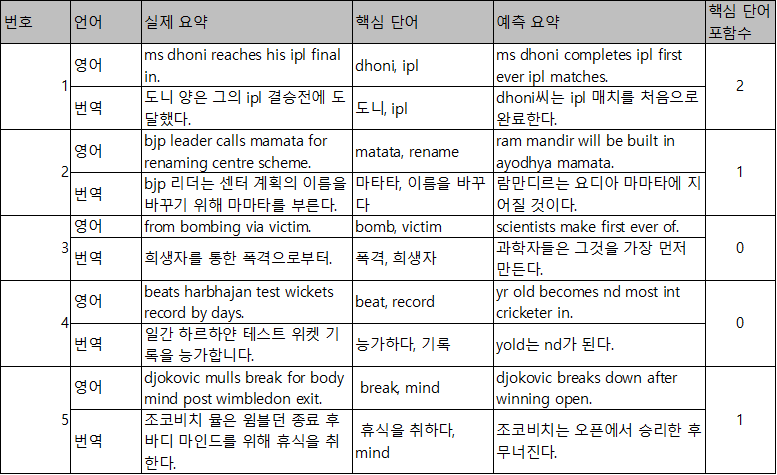

실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었는지 확인했다.

# 5. Summa을 이용해서 추출적 요약해보기

이번엔 추출적 요약을 한 번 해보자.

In [136]:
data1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data1.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [137]:
print('Text:')
print(data1['text'][0])
print()
print('Abstractive Summary:')
print(summarize(data1['text'][0], ratio=0.5))

Text:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

Abstractive Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


3번째 문장이 가장 중요하다고 생각한 것 같다.

In [138]:
def abstractive_summa_1(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = src_tokenizer.texts_to_sequences([sentence])[0]
    
    return sentence
    
def abstractive_summa_2(sentence):
    sentence = pad_sequences([sentence], maxlen=text_max_len, padding='post')[0]
    sentence = np.array(sentence)
    sentence = decode_sequence(sentence.reshape(1, text_max_len))
    
    return sentence

In [141]:
for i in range(1, 6):
    text = data1['text'][i]
    tokens = abstractive_summa_1(text)
    if len(tokens) > text_max_len:
        continue
    
    headline = data1['headlines'][i]
    print(f'{i + 1}번째')
    print("원문 :", text)
    print("실제 요약 :", headline)
    print("추상적 예측 요약 :", abstractive_summa_2(tokens))
    print("추출적 예측 요약 :", summarize(text, ratio=0.5))
    print("\n")

2번째
원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추상적 예측 요약 :  aadhaar card payments card card
추출적 예측 요약 : Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


3번째
원문 : New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket histor

영어를 못해서 문법완성도 측면에서 잘 비교하지는 못하겠지만 말은 되는 것 같다.  
핵심 단어 포함 여부라도 잘 비교해보자.

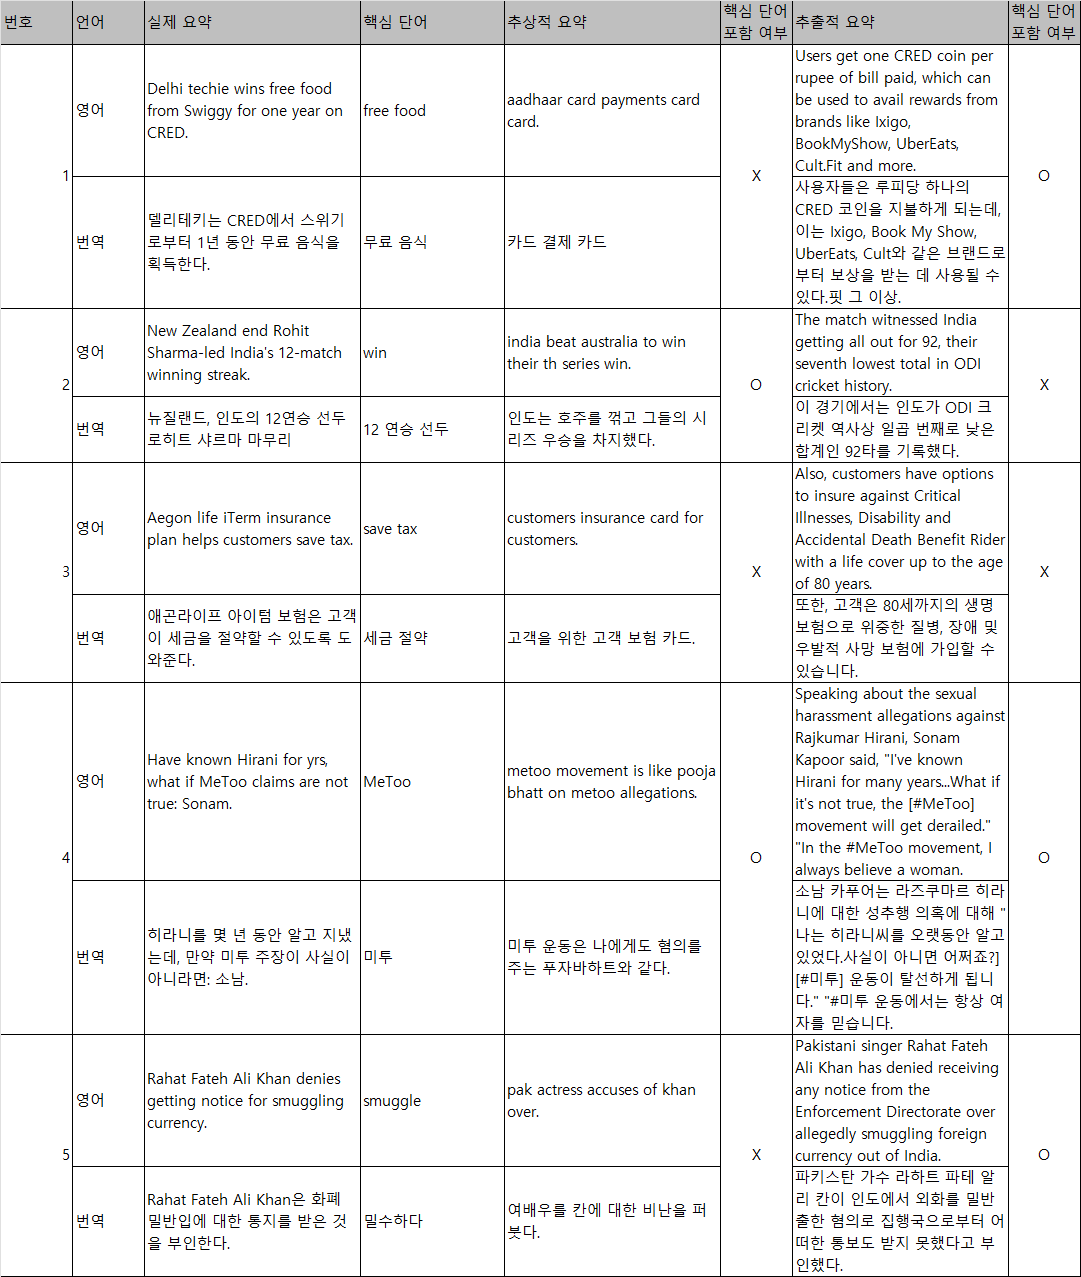

성능은 추출적 요약이 더 잘나왔다.

# 6. 번외편: Subclassing API 사용해보기

모델을 Subclassing API로 구현해보자.

In [142]:
# class CustomModel(Model):
#     def __init__(self, src_vocab, embedding_dim, hidden_size, tar_vocab):
#         super().__init__()

#         self.encoder_emb = Embedding(src_vocab, embedding_dim)
#         self.encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout=0.4)
#         self.encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
#         self.encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
        
#         self.dec_emb_layer = Embedding(tar_vocab, embedding_dim)
#         self.decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
        
#         self.decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
        
#     def call(self, inputs):
#         encoder_inputs, decoder_inputs = inputs
#         enc_emb = self.encoder_emb(encoder_inputs)
#         encoder_output1, state_h1, state_c1 = self.encoder_lstm1(enc_emb)
#         encoder_output2, state_h2, state_c2 = self.encoder_lstm2(encoder_output1)
#         encoder_outputs, state_h, state_c = self.encoder_lstm3(encoder_output2)
        
#         dec_emb = self.dec_emb_layer(decoder_inputs)
#         decoder_outputs, _, _ = self.decoder_lstm(dec_emb, initial_state=[state_h, state_c])
        
#         decoder_softmax_outputs = self.decoder_softmax_layer(decoder_outputs)

#         return decoder_softmax_outputs
        
# # 모델 정의
# model = CustomModel(src_vocab, embedding_dim, hidden_size, tar_vocab)


In [143]:
class CustomModel(Model):
    def __init__(self, src_vocab, embedding_dim, hidden_size, tar_vocab):
        super().__init__()
        
        self.encoder_emb = Embedding(src_vocab, embedding_dim)
        self.encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout=0.4)
        self.encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
        self.encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
        
        self.dec_emb_layer = Embedding(tar_vocab, embedding_dim)
        self.decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
        
        self.attn_layer = AdditiveAttention(name='attention_layer')
        self.decoder_concat = Concatenate(axis=-1, name='concat_layer')
        
        self.decoder_softmax_layer = Dense(tar_vocab, activation='softmax')

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs
        enc_emb = self.encoder_emb(encoder_inputs)
        encoder_output1, state_h1, state_c1 = self.encoder_lstm1(enc_emb)
        encoder_output2, state_h2, state_c2 = self.encoder_lstm2(encoder_output1)
        encoder_outputs, state_h, state_c = self.encoder_lstm3(encoder_output2)
        
        dec_emb = self.dec_emb_layer(decoder_inputs)
        decoder_outputs, _, _ = self.decoder_lstm(dec_emb, initial_state=[state_h, state_c])
        
        attn_out = self.attn_layer([decoder_outputs, encoder_outputs])
        decoder_concat_input = self.decoder_concat([decoder_outputs, attn_out])
        
        decoder_softmax_outputs = self.decoder_softmax_layer(decoder_concat_input)
        
        return decoder_softmax_outputs

# 모델 정의
model = CustomModel(src_vocab, embedding_dim, hidden_size, tar_vocab)


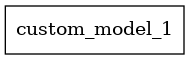

In [144]:
plot_model(model, show_shapes=True)

In [145]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 29s 89ms/step - loss: 5.5488 - accuracy: 0.2686 - val_loss: 5.2279 - val_accuracy: 0.2881
Epoch 2/50
269/269 [==============================] - 23s 86ms/step - loss: 5.0245 - accuracy: 0.2948 - val_loss: 4.8087 - val_accuracy: 0.3082
Epoch 3/50
269/269 [==============================] - 23s 85ms/step - loss: 4.6633 - accuracy: 0.3127 - val_loss: 4.5118 - val_accuracy: 0.3245
Epoch 4/50
269/269 [==============================] - 23s 85ms/step - loss: 4.3922 - accuracy: 0.3279 - val_loss: 4.3203 - val_accuracy: 0.3380
Epoch 5/50
269/269 [==============================] - 23s 85ms/step - loss: 4.1794 - accuracy: 0.3419 - val_loss: 4.1899 - val_accuracy: 0.3483
Epoch 6/50
269/269 [==============================] - 23s 86ms/step - loss: 4.0056 - accuracy: 0.3536 - val_loss: 4.0855 - val_accuracy: 0.3559
Epoch 7/50
269/269 [==============================] - 23s 85ms/step - loss: 3.8565 - accuracy: 0.3647 - val_loss: 3.9767 - val_accuracy:

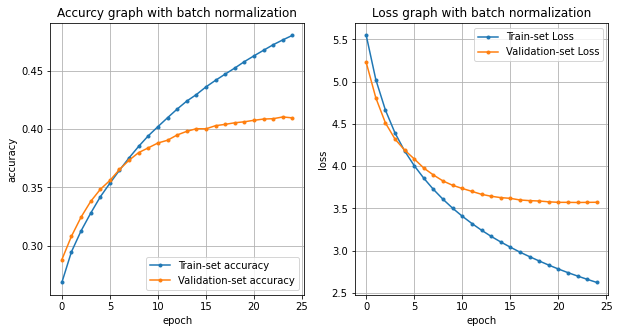

In [146]:
history_plot(history)

In [147]:
class CustomModel1(Model):
    def __init__(self, src_vocab, embedding_dim, hidden_size):
        super().__init__()
        
        self.encoder_emb = Embedding(src_vocab, embedding_dim)
        self.encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout=0.4)
        self.encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
        self.encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)

    def call(self, encoder_inputs):
        enc_emb = self.encoder_emb(encoder_inputs)
        encoder_output1, state_h1, state_c1 = self.encoder_lstm1(enc_emb)
        encoder_output2, state_h2, state_c2 = self.encoder_lstm2(encoder_output1)
        encoder_outputs, state_h, state_c = self.encoder_lstm3(encoder_output2)
                
        return [encoder_outputs, state_h, state_c]

# 인코더 설계
encoder_model = CustomModel1(src_vocab, embedding_dim, hidden_size)

In [148]:
class CustomModel2(Model):
    def __init__(self, tar_vocab, embedding_dim, hidden_size):
        super().__init__()
        
        self.dec_emb_layer = Embedding(tar_vocab, embedding_dim)
        self.decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
        
        self.attn_layer = AdditiveAttention(name='attention_layer')
        self.decoder_concat = Concatenate(axis=-1, name='concat')
        
        self.decoder_softmax_layer = Dense(tar_vocab, activation='softmax')

    def call(self, inputs):
        decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c = inputs

        dec_emb2 = self.dec_emb_layer(decoder_inputs)
        decoder_outputs2, state_h2, state_c2 = self.decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
        
        attn_out_inf = self.attn_layer([decoder_outputs2, decoder_hidden_state_input])
        decoder_inf_concat = self.decoder_concat([decoder_outputs2, attn_out_inf])
        
        decoder_outputs2 = self.decoder_softmax_layer(decoder_inf_concat)
        
        return [decoder_outputs2] + [state_h2, state_c2]
    
# 최종 디코더 모델
decoder_model = CustomModel2(tar_vocab, embedding_dim, hidden_size)

In [149]:
for i in range(5):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")
    

원문 : ms dhoni become first cricketer reach eight ipl finals following csk victory srh ipl qualifier tuesday year old led csk six finals winning twice played rising pune supergiant last year final scored runs seven previous finals strike rate 
실제 요약 : ms dhoni reaches his ipl final in 
예측 요약 :  brazil flat call malware documents status ambassador clean compensation google


원문 : changing names central government schemes bjp leader chandra kumar bose compared west bengal cm mamata banerjee mughal emperor demolished ram temple ayodhya built babri masjid think mamata give name state level scheme centre actually adopted bose added 
실제 요약 : bjp leader calls mamata for renaming centre scheme 
예측 요약 :  took surprise videos elderly actors lists khanna surname surname nehru


원문 : first brazilian scientists used one victims much radiation people may subjected bombing using technique called spin designed dating fossils researchers analysed bone tissue found radiation levels nearly double fatal 
실

그만 알아보도록 하자...

# 7. 회고하기

## 7.1. 이번 프로젝트에서 어려웠던 점

어려웠던 점은 딱히 없었는데 일을 만들어서 한 나머지 시간이 빠듯했다.

만든 일들은 크게 2가지다.  
첫번째:  
train, test 데이터셋을 너무 일찍 나눠서 함수들을 두번씩 적용하는 느낌이라  
여러 함수들을 먼저 적용하고 나중에 데이터셋을 나누려고 했는데  
오히려 더 꼬여버려서 그냥 딱 저 타이밍에 하는 게 나아서 원상복구했다.  
두번째:  
Subclassing API으로 모델을 만들어봤는데 제대로 작동이 안된다.  
훈련까지는 잘 된 거 같은데 테스트에서 문제가 발생한 거 같다.
일단 돌아가긴 했다는 것에 만족해야겠다.

## 7.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

어텐션 레이어 알고리즘을 상상도 못했는데  
이런 메커니즘을 만들어 낸 전문가들이 대단하다고 느꼈다.  
그래도 아직 내부적으로 어떻게 돌아가는지는 이해하지 못했다.

## 7.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

노드 페이지를 따라서 하면서 전처리, 학습, 테스트를 진행하면 된다.  
최근 들어 쉬운 편인 루브릭이라 무난하게 달성한 것 같다.

## 7.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

아마 루브릭 해석을 잘못한 것이 아닐까 싶다.

## 7.5. 자기 다짐

이번에 subclassing api도 루브릭 외적으로 시도해봤는데  
subclassing api도 만능은 아니라는 생각이 들었다.  
functional에 비해 유동적으로 쓸 수가 없고  
각각 class를 또 만들어야 되는 것 같다.  

어텐션 메커니즘도 배워봤는데 거의 뭐 이론상 완벽해 보이긴 한데  
더 진보된 메커니즘이 있는지 궁금했다.